# ETL & Data Processing

## 1. Set up

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
%cd ..
# %cd media/capstone-project

D:\OneDrive\w210\capstone-project


In [2]:
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

%matplotlib inline
sns.set_theme(color_codes=True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

In [1]:
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

starting Spark


RuntimeError: Java gateway process exited before sending its port number

In [5]:
spark

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 2. EDA

In [12]:
raw_data = pd.read_csv('data/ddis_from_api.csv', delimiter='\t')
# Filter out drug_pairs without SMILES data
# raw_data = raw_data.dropna(subset=['smiles1', 'smiles2'], how='any')
raw_data = raw_data.drop_duplicates()

# Add a drug-pair column 
raw_data['d1_d2'] = raw_data.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
raw_data['drug_pair'] = raw_data.apply(lambda x: str(set(sorted([x['d1'], x['d2']]))), axis=1)

print('Raw data dimension:', raw_data.shape)
print('Number of distinct drugs in d1:', len(raw_data['d1'].unique()))
print('Number of distinct drugs in d2:', len(raw_data['d2'].unique()))
print('Number of distinct d1-d2 sequence:', len(raw_data['d1_d2'].unique()))
print('Number of distinct drug-pair:', len(raw_data['drug_pair'].unique()))
raw_data.head()

Raw data dimension: (1357134, 11)
Number of distinct drugs in d1: 2407
Number of distinct drugs in d2: 2441
Number of distinct d1-d2 sequence: 1357134
Number of distinct drug-pair: 731443


,d1,d2,d1_name,d2_name,interaction,severity,smiles1,smiles2,interaction_type,d1_d2,drug_pair
0,DB00006,DB02709,Bivalirudin,Resveratrol,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,OC1=CC=C(\C=C\C2=CC(O)=CC(O)=C2)C=C1,1,"['DB00006', 'DB02709']","{'DB02709', 'DB00006'}"
1,DB00006,DB01435,Bivalirudin,Antipyrine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CN1N(C(=O)C=C1C)C1=CC=CC=C1,2,"['DB00006', 'DB01435']","{'DB00006', 'DB01435'}"
2,DB00006,DB08867,Bivalirudin,Ulipristal,The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.,unknown,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CN(C)C1=CC=C(C=C1)[C@H]1C[C@@]2(C)[C@@H](CC[C@]2(O)C(C)=O)[C@@H]2CCC3=CC(=O)CCC3=C12,3,"['DB00006', 'DB08867']","{'DB08867', 'DB00006'}"
3,DB00006,DB00428,Bivalirudin,Streptozocin,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CN(N=O)C(=O)N[C@H]1[C@@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O,1,"['DB00006', 'DB00428']","{'DB00428', 'DB00006'}"
4,DB00006,DB01138,Bivalirudin,Sulfinpyrazone,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,O=C1C(CCS(=O)C2=CC=CC=C2)C(=O)N(N1C1=CC=CC=C1)C1=CC=CC=C1,1,"['DB00006', 'DB01138']","{'DB01138', 'DB00006'}"


In [13]:
# Count the number of repeated pairs in the dataset
count_pair = dict(raw_data.d1_d2.value_counts())

# Display drug-pairs that have more than 1 interaction in the dataset
raw_data['count_pair'] = raw_data.d1_d2.map(count_pair)

pair_1count = len(raw_data[raw_data.count_pair == 1]['d1_d2'].unique())
pair_2count = len(raw_data[raw_data.count_pair > 1]['d1_d2'].unique())
print('Number of drug-pairs have 1 interaction:', pair_1count)
print('Number of drug-pairs have >1 interactions:', pair_2count)
# raw_data[raw_data.count_pair > 1].sort_values('d1_d2')

Number of drug-pairs have 1 interaction: 1357134
Number of drug-pairs have >1 interactions: 0


In [14]:
# Number of distinct Drugs in the dataset
all_drug_id = set(raw_data['d1'].unique()) | set(raw_data['d2'].unique())
print('Number of distinct drugs:', len(all_drug_id))

Number of distinct drugs: 2441


## 3. Extract Drug-Pair With Unknown-Interaction (Negative Control)

In [15]:
# SMILES dataset
drug_smiles = pd.read_csv('data/archive/drug_smiles.csv')
drug_smiles = drug_smiles[['drug_id', 'smiles']]

print('Drug Smiles dimension:', drug_smiles.shape)
drug_smiles.head()

Drug Smiles dimension: (1704, 2)


,drug_id,smiles
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1,DB00855,NCC(=O)CCC(O)=O
2,DB09536,O=[Ti]=O
3,DB01878,O=C(C1=CC=CC=C1)C1=CC=CC=C1
4,DB00140,CC1=C(C)C=C2N(C[C@H](O)[C@H](O)[C@H](O)CO)C3=NC(=O)NC(=O)C3=NC2=C1


In [16]:
# All potential Drug-Pair could be formed in the database
all_pairs = {str(set(pair)) for pair in itertools.combinations(sorted(drug_smiles.drug_id), 2)}
# all_pairs = {str(set(pair)) for pair in itertools.combinations(sorted(all_drug_id), 2)}
print("Total pairs could be formed:", len(all_pairs))

# All drug-pair with known interactions
interact_pairs = {pair for pair in raw_data.drug_pair.unique()}
print("Number of pairs have interactions:", len(interact_pairs))

# All drug-pair with NO interactions found
# negative_pairs = [pair for pair in all_pairs if pair not in interact_pairs]
negative_pairs = all_pairs - interact_pairs
print("Number of pairs with NO interactions found:", len(negative_pairs))

print("Quick look of negative control drug pairs:")
list(negative_pairs)[:10]

Total pairs could be formed: 1450956
Number of pairs have interactions: 731443
Number of pairs with NO interactions found: 1036287
Quick look of negative control drug pairs:


["{'DB01033', 'DB00542'}",
 "{'DB00637', 'DB00240'}",
 "{'DB00839', 'DB00963'}",
 "{'DB09069', 'DB09090'}",
 "{'DB06216', 'DB08895'}",
 "{'DB01227', 'DB00905'}",
 "{'DB04878', 'DB01610'}",
 "{'DB00454', 'DB00417'}",
 "{'DB01612', 'DB00728'}",
 "{'DB00976', 'DB06704'}"]

In [17]:
def convert_pair_to_df(negative_pairs):
    string_rdd = sc.parallelize(list(negative_pairs))
    negative_rdd = string_rdd.map(lambda x: re.sub('[{}\']', '', x).split(", "))
    negative_df = negative_rdd.toDF(["d1", "d2"]).toPandas()
    return negative_df
    
# negative_df = convert_pair_to_df(negative_pairs)
# negative_df

In [18]:
negative_df = pd.DataFrame(negative_pairs)
negative_df.columns = ['drug_pair']
negative_df['d1'] = negative_df['drug_pair'].apply(lambda x: re.sub('[{}\']', '', x).split(", ")[0])
negative_df['d2'] = negative_df['drug_pair'].apply(lambda x: re.sub('[{}\']', '', x).split(", ")[1])
negative_df = negative_df.drop('drug_pair', axis=1)
negative_df

,d1,d2
0,DB01033,DB00542
1,DB00637,DB00240
2,DB00839,DB00963
3,DB09069,DB09090
4,DB06216,DB08895
...,...,...
1036282,DB08871,DB11574
1036283,DB00428,DB01070
1036284,DB12483,DB12598
1036285,DB12070,DB00443


In [27]:
# Drug Name
drug_names = pd.read_csv('data/archive/drugbank vocabulary.csv')
drug_names = drug_names[['DrugBank ID', 'Common name']]
# drug_names = pd.read_csv('data/scraping_drug_info.csv', delimiter='\t')
# drug_names = drug_names[['drug_id', 'generic_name', 'SMILES']]
drug_names = drug_names.rename(columns={'DrugBank ID': 'drug_id', 'Common name':'name'})

print('Drug Names dimension:', drug_names.shape)
drug_names.head()

Drug Names dimension: (15235, 2)


,drug_id,name
0,DB00001,Lepirudin
1,DB00002,Cetuximab
2,DB00003,Dornase alfa
3,DB00004,Denileukin diftitox
4,DB00005,Etanercept


In [50]:
# SMILES dataset
drug_smiles2 = pd.read_csv('data/scraping_drug_smiles.csv')
drug_smiles2 = drug_smiles2[drug_smiles2["SMILES"] != "Not Available"]
# drug_smiles2 = drug_smiles2[['drug_id', 'smiles']]

print('Drug Smiles dimension From Web Scraping:', drug_smiles2.shape)
drug_smiles2.head()

Drug Smiles dimension From Web Scraping: (2567, 3)


,drug_id,generic_name,SMILES
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...
1,DB00007,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](CC1...
2,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=C...
3,DB00027,Gramicidin D,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](C(C)C)...
4,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)CCSSC[C@H](NC(=O)[C@H]...


In [51]:
# Add Interaction Type and Smiles1, Smiles 2 into negative_df
merged_df = pd.merge(negative_df, drug_smiles2, left_on="d1", right_on="drug_id", how="left")
merged_df = merged_df.rename(columns={"generic_name": "d1_name", "SMILES": "smiles1"})
# merged_df = pd.merge(negative_df, drug_names, left_on="d1", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"name": "d1_name"})

merged_df = pd.merge(merged_df, drug_smiles2, left_on="d2", right_on="drug_id", how="left")
merged_df = merged_df.rename(columns={"generic_name": "d2_name", "SMILES": "smiles2"})
# merged_df = pd.merge(merged_df, drug_names, left_on="d2", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"name": "d2_name"})                                      

merged_df['interaction'] = 'Unknown'
merged_df['interaction_type'] = 0
merged_df['severity'] = 'unknown'

# merged_df = pd.merge(merged_df, drug_smiles, left_on="d1", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"smiles": "smiles1"})

# merged_df = pd.merge(merged_df, drug_smiles, left_on="d2", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"smiles": "smiles2"})

merged_df = merged_df[['d1', 'd2', 'd1_name', 'd2_name', 'interaction','interaction_type', 'severity', 'smiles1', 'smiles2']]
merged_df

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB01033,DB00542,Mercaptopurine,Benazepril,Unknown,0,unknown,S=C1N=CNC2=C1NC=N2,[H][C@@]1(CCC2=CC=CC=C2N(CC(O)=O)C1=O)N[C@@H](CCC1=CC=CC=C1)C(=O)OCC
1,DB00637,DB00240,Astemizole,Alclometasone,Unknown,0,unknown,COC1=CC=C(CCN2CCC(CC2)NC2=NC3=CC=CC=C3N2CC2=CC=C(F)C=C2)C=C1,[H][C@@]12C[C@@H](C)[C@](O)(C(=O)CO)[C@@]1(C)C[C@H](O)[C@@]1([H])[C@@]2([H])[C@H](Cl)CC2=CC(=O)C...
2,DB00839,DB00963,Tolazamide,Bromfenac,Unknown,0,unknown,CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NN1CCCCCC1,NC1=C(CC(O)=O)C=CC=C1C(=O)C1=CC=C(Br)C=C1
3,DB09069,DB09090,Trimetazidine,Pinaverium,Unknown,0,unknown,COC1=C(OC)C(OC)=C(CN2CCNCC2)C=C1,COC1=C(OC)C=C(C[N+]2(CCOCCC3CCC4CC3C4(C)C)CCOCC2)C(Br)=C1
4,DB06216,DB08895,Asenapine,Tofacitinib,Unknown,0,unknown,CN1CC2C(C1)C1=C(OC3=CC=C(Cl)C=C23)C=CC=C1,C[C@@H]1CCN(C[C@@H]1N(C)C1=NC=NC2=C1C=CN2)C(=O)CC#N
...,...,...,...,...,...,...,...,...,...
1036282,DB08871,DB11574,Eribulin,Elbasvir,Unknown,0,unknown,[H][C@@]12CC(=C)[C@]([H])(CC[C@@]3([H])C[C@@H](C)C(=C)[C@@]([H])(C[C@]4([H])O[C@H](C[C@H](O)CN)[...,[H][C@]1(CCCN1C(=O)[C@@H](NC(=O)OC)C(C)C)C1=NC=C(N1)C1=CC2=C(C=C1)N1[C@@H](OC3=C(C=CC(=C3)C3=CN=...
1036283,DB00428,DB01070,Streptozocin,Dihydrotachysterol,Unknown,0,unknown,CN(N=O)C(=O)N[C@H]1[C@@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O,CC(C)[C@@H](C)\C=C\[C@@H](C)[C@@]1([H])CC[C@@]2([H])\C(CCC[C@]12C)=C\C=C1/C[C@@H](O)CC[C@@H]1C
1036284,DB12483,DB12598,Copanlisib,Nafamostat,Unknown,0,unknown,COC1=C(OCCCN2CCOCC2)C=CC2=C1N=C(NC(=O)C1=CN=C(N)N=C1)N1CCN=C21,NC(=N)NC1=CC=C(C=C1)C(=O)OC1=CC2=C(C=C1)C=C(C=C2)C(N)=N
1036285,DB12070,DB00443,Letermovir,Betamethasone,Unknown,0,unknown,COC1=CC=CC(=C1)N1CCN(CC1)C1=NC2=C(C=CC=C2F)[C@H](CC(O)=O)N1C1=CC(=CC=C1OC)C(F)(F)F,[H][C@@]12C[C@H](C)[C@](O)(C(=O)CO)[C@@]1(C)C[C@H](O)[C@@]1(F)[C@@]2([H])CCC2=CC(=O)C=C[C@]12C


## 4. Combine Interaction Data & Negative Control Data

In [84]:
raw_data = raw_data[['d1', 'd2', 'd1_name', 'd2_name', 'interaction','interaction_type', 'severity', 'smiles1', 'smiles2']]
master_df = pd.concat([merged_df, raw_data])
master_df = master_df.dropna(subset=['smiles1', 'smiles2'], how='any')
master_df = master_df.drop_duplicates()
master_df = master_df.sort_values(by='d1')

master_df.reset_index(inplace=True)
master_df = master_df.drop('index', axis=1)

print("Shape of Master data:", master_df.shape)
print('Number of distinct drugs in d1:', len(master_df['d1'].unique()))
print('Number of distinct drugs in d2:', len(master_df['d2'].unique()))
total_drugs = set(master_df['d1'].unique()) | set(master_df['d2'].unique())
print('Number of distinct drugs:', len(total_drugs))
print("Value Count of Interaction Type")
print(master_df['interaction_type'].value_counts())
# print("Value Count of Interaction Type - Bottom 20:")
# print(master_df['interaction_type'].value_counts()[-20:])
print('Number of missing values:\n', master_df.isnull().sum())

Shape of Master data: (2373051, 9)
Number of distinct drugs in d1: 2536
Number of distinct drugs in d2: 2566
Number of distinct drugs: 2566
Value Count of Interaction Type
0     1015917
6      180527
10     122789
11     116559
29     106829
       ...   
53        863
30        841
61        837
80        833
42        826
Name: interaction_type, Length: 87, dtype: int64
Number of missing values:
 d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
interaction_type    0
severity            0
smiles1             0
smiles2             0
dtype: int64


In [58]:
master_df.head()

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00006,DB04552,Bivalirudin,Niflumic acid,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,OC(=O)C1=C(NC2=CC=CC(=C2)C(F)(F)F)N=CC=C1
1,DB00006,DB00244,Bivalirudin,Mesalazine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,NC1=CC(C(O)=O)=C(O)C=C1
2,DB00006,DB00488,Bivalirudin,Altretamine,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C
3,DB00006,DB04743,Bivalirudin,Nimesulide,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CS(=O)(=O)NC1=C(OC2=CC=CC=C2)C=C(C=C1)[N+]([O-])=O
4,DB00006,DB00999,Bivalirudin,Hydrochlorothiazide,The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.,3,unknown,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,NS(=O)(=O)C1=C(Cl)C=C2NCNS(=O)(=O)C2=C1


In [86]:
master_df[master_df["smiles2"].isnull()]

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2


In [4]:
# Save data
# master_df.to_csv("data/ddis_from_api_negative_control.csv", index=False, sep='\t')
master_df = pd.read_csv('data/ddis_from_api_negative_control.csv', sep='\t')

In [88]:
test_drug = master_df[master_df['d1']=='DB00338']
print(test_drug.shape)
# test_drug.head(2)
test_drug[test_drug['interaction_type'] != 0][test_drug['severity'] == 'high'].head(2)

(1263, 9)


C:\Users\ltmai\AppData\Local\Temp\ipykernel_14440\4120952950.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_drug[test_drug['interaction_type'] != 0][test_drug['severity'] == 'high'].head(2)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
227476,DB00338,DB01166,Omeprazole,Cilostazol,The serum concentration of #Drug2 can be increased when it is combined with #Drug1.,16,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,O=C1CCC2=C(N1)C=CC(OCCCCC1=NN=NN1C1CCCCC1)=C2
227483,DB00338,DB01244,Omeprazole,Bepridil,The metabolism of #Drug2 can be decreased when combined with #Drug1.,29,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,CC(C)COCC(CN(CC1=CC=CC=C1)C1=CC=CC=C1)N1CCCC1


In [103]:
test_drug[test_drug['d2_name'] == "Testosterone"]

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
228060,DB00338,DB00624,Omeprazole,Testosterone,#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.,11,unknown,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CCC2=CC(=O)CC[C@]12C


In [89]:
# Add a drug-pair column 
master_df['d1_d2'] = master_df.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
# raw_data['drug_pair'] = raw_data.apply(lambda x: str(set(sorted([x['d1'], x['d2']]))), axis=1)

print('Raw data dimension:', master_df.shape)
print('Number of distinct drugs in d1:', len(master_df['d1'].unique()))
print('Number of distinct drugs in d2:', len(master_df['d2'].unique()))
print('Number of distinct d1-d2 sequence:', len(master_df['d1_d2'].unique()))

Raw data dimension: (2373051, 10)
Number of distinct drugs in d1: 2536
Number of distinct drugs in d2: 2566
Number of distinct d1-d2 sequence: 2373051


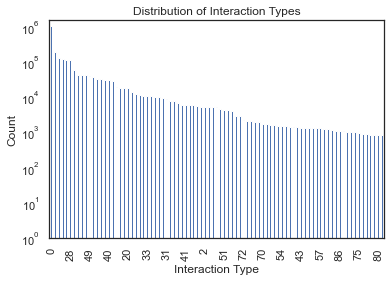

In [90]:
master_df['interaction_type'].value_counts().plot(kind='bar', logy=True)
sns.set_style('white')

plt.ylabel('Count')
plt.xlabel('Interaction Type')
plt.title('Distribution of Interaction Types')
labels = list(range(0, 90, 5))
plt.xticks(labels)
plt.ylim(bottom=1) 
plt.show()

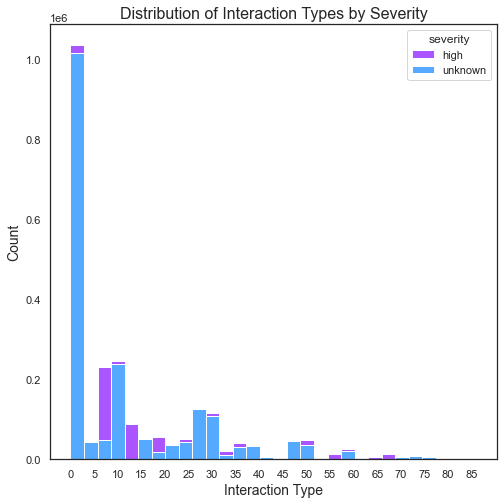

In [105]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=master_df, x='interaction_type', bins = 30, alpha=1, hue="severity", multiple="stack", palette='cool_r')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Interaction Type', fontsize=14)
plt.title('Distribution of Interaction Types by Severity', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 90, 5))
plt.xticks(labels)
plt.show()

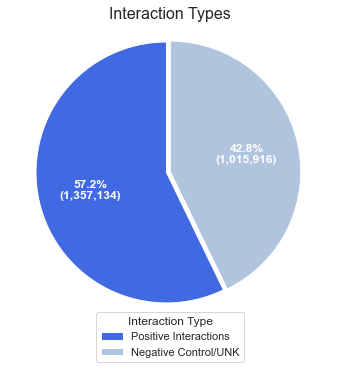

In [92]:
data = [master_df[master_df['interaction_type'] != 0].shape[0], master_df[master_df['interaction_type'] == 0].shape[0]]
labels = ['Top 86 Interactions', 'Negative Control/UNK']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Interaction Type",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1)
         )

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Interaction Types", fontsize=16, y=0.95)
plt.show()

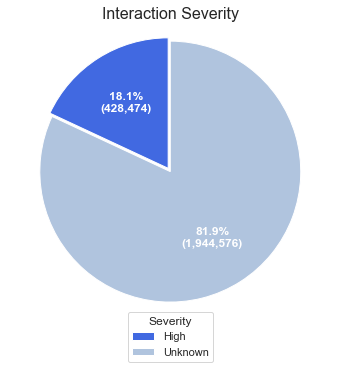

In [93]:
data = [master_df[master_df['severity'] == 'high'].shape[0], master_df[master_df['severity'] != 'high'].shape[0]]
labels = ['High', 'Unknown']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Severity",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Interaction Severity", fontsize=16, y=0.95)
plt.show()

In [94]:
# Save new interaction_information
interaction_df = master_df[['interaction_type', 'interaction']]
interaction_df = interaction_df.drop_duplicates().sort_values('interaction_type')
interaction_df.reset_index(inplace=True)
interaction_df = interaction_df.drop('index', axis=1)
interaction_df

,interaction_type,interaction
0,0,Unknown
1,1,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.
2,2,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.
3,3,The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.
4,4,#Drug2 may increase the anticoagulant activities of #Drug1.
...,...,...
82,82,#Drug2 may increase the neuroexcitatory activities of #Drug1.
83,83,#Drug2 may increase the orthostatic hypotensive activities of #Drug1.
84,84,"#Drug1 may increase the orthostatic hypotensive, hypotensive, and antihypertensive activities of #Drug2."
85,85,The risk or severity of hypotension and CNS depression can be increased when #Drug1 is combined with #Drug2.


In [95]:
# save the dataframe to csv file
interaction_df.to_csv('data/interaction_information_api.csv', index=False, sep='\t')

## 5. Train / Test Split

In [6]:
master_df.head(2)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00006,DB04552,Bivalirudin,Niflumic acid,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,OC(=O)C1=C(NC2=CC=CC(=C2)C(F)(F)F)N=CC=C1
1,DB00006,DB00244,Bivalirudin,Mesalazine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1=CC(C(O)=O)=C(O)C=C1


In [12]:
## Extract Bit in the Approved Group
drug_info_df = pd.read_csv('data/scraping_drug_info.csv', delimiter='\t')
approved_drugs = drug_info_df[drug_info_df["approved_drug"] == 1]["drug_id"].values
not_approved_drugs = drug_info_df[drug_info_df["approved_drug"] == 0]["drug_id"].values
print("Number of approved drugs:", len(approved_drugs))
print("Number of not approved drugs:", len(not_approved_drugs))

# Extract DDI for approved drugs for train set
not_approved_df = master_df[master_df["d1"].isin(not_approved_drugs) | master_df["d2"].isin(not_approved_drugs)]
approved_df = master_df[master_df["d1"].isin(approved_drugs) & master_df["d2"].isin(approved_drugs)]
print("Approved drugs DDIS: ", approved_df.shape)
print("Not Approved Drugs DDIS: ", not_approved_df.shape)


Number of approved drugs: 2040
Number of not approved drugs: 527


In [121]:
print(approved_drugs[:10])
not_approved_drugs[:10]

['DB00006' 'DB00007' 'DB00014' 'DB00027' 'DB00035' 'DB00067' 'DB00080'
 'DB00091' 'DB00115' 'DB00118']


array(['DB00127', 'DB00155', 'DB00168', 'DB00212', 'DB00232', 'DB00269',
       'DB00453', 'DB00463', 'DB00505', 'DB00546'], dtype=object)

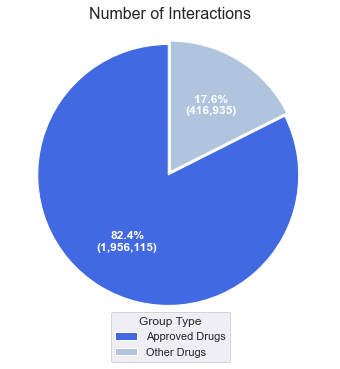

In [12]:
data = [approved_df.shape[0], not_approved_df.shape[0]]
labels = ['Approved Drugs', 'Other Drugs']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Group Type",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Number of Interactions", fontsize=16, y=0.95)
plt.show()

In [107]:
# Save Not Approved Drugs for test set
val_test_drug_split = round(len(not_approved_drugs)/2)
np.random.shuffle(not_approved_drugs)
val_drugs = not_approved_drugs[:val_test_drug_split]

val_df = not_approved_df[not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs)]
test_df = not_approved_df[~(not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs))]

val_df = val_df.sample(frac=1, random_state=42)
val_df = val_df.reset_index()
val_df = val_df.drop('index', axis=1)
test_df = test_df.sample(frac=1, random_state=42)
test_df = test_df.reset_index()
test_df = test_df.drop('index', axis=1)

# Save test set
# save the dataframe to csv file
# not_approved_df.to_csv('data/ddi_test_api.csv', index=False)

C:\Users\ltmai\AppData\Local\Temp\ipykernel_21160\3514456395.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = not_approved_df[not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs)]
C:\Users\ltmai\AppData\Local\Temp\ipykernel_21160\3514456395.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = not_approved_df[~(not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs))]


In [114]:
print('Test dataset shape:', test_df.shape)
print('Number of interaction types in test set:', len(test_df.interaction_type.unique()))
print('Interaction type distribution in test set, Bottom 10:')
print(test_df.interaction_type.value_counts()[-10:])
test_df.head(1)

Test dataset shape: (214302, 9)
Number of interaction types in test set: 87
Interaction type distribution in test set, Bottom 10:
81    91
53    75
37    72
5     55
38    54
30    49
42    41
69    40
75    31
80    26
Name: interaction_type, dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB13868,DB00319,Adefovir,Piperacillin,#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.,11,unknown,NC1=C2N=CN(CCOCP(O)(O)=O)C2=NC=N1,[H][C@]12SC(C)(C)[C@@H](N1C(=O)[C@H]2NC(=O)[C@H](NC(=O)N1CCN(CC)C(=O)C1=O)C1=CC=CC=C1)C(O)=O


In [115]:
print('Validation dataset shape:', val_df.shape)
print('Number of interaction types in Validation set:', len(val_df.interaction_type.unique()))
print('Interaction type distribution in Validation set, Bottom 10:')
print(val_df.interaction_type.value_counts()[-10:])
val_df.head(1)

Validation dataset shape: (202633, 9)
Number of interaction types in Validation set: 87
Interaction type distribution in Validation set, Bottom 10:
53    60
37    53
80    52
69    52
84    37
30    26
44    25
17    22
42    19
86    12
Name: interaction_type, dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00770,DB01094,Alprostadil,Hesperetin,Unknown,0,unknown,CCCCC[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C@@H]1CCCCCCC(O)=O,COC1=C(O)C=C(C=C1)[C@@H]1CC(=O)C2=C(O)C=C(O)C=C2O1


In [117]:
approved_df.head(1)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
1,DB00006,DB00244,Bivalirudin,Mesalazine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1=CC(C(O)=O)=C(O)C=C1


In [119]:
# save the dataframe to csv file
test_df.to_csv('data/ddi_test_api.csv', index=False, sep='\t')
val_df.to_csv('data/ddi_val_api.csv', index=False, sep='\t')
approved_df.to_csv('data/ddi_train_api.csv', index=False, sep='\t')

In [4]:
approved_df = pd.read_csv('data/ddi_train_api.csv', sep='\t')

## 6. Under-Sampling & Up-Sampling

In [5]:
# Set the display.max_rows option to None
pd.set_option("display.max_rows", None)

print('Training set label distribution:')
approved_df = approved_df[["d1", "d2", "interaction_type", "severity"]]
approved_df.interaction_type.value_counts()

Training set label distribution:


0     848461
6     125863
10    108931
11    108926
28     96455
29     96452
12     48208
3      30934
7      30934
24     28478
16     28477
49     28345
48     28344
40     26142
35     26139
19     24466
14     23847
15     14737
22     14736
20     12338
21     12338
25     10388
26     10385
1       9097
59      8021
60      8021
33      7686
68      6724
31      6696
8       6696
27      6609
34      6609
36      6598
13      5338
23      4540
41      4430
47      4429
50      4420
55      4166
64      4038
58      4024
2       3536
9       3396
51      3366
73      2913
76      2913
56      2910
46      2860
39      2218
62      2218
72      1681
71      1681
52      1544
54      1314
70      1314
45      1303
44      1303
79      1277
32      1277
67      1256
38      1255
43      1128
18      1089
78      1089
17      1010
66      1008
5        954
4        953
86       943
84       942
37       932
83       895
74       895
63       814
82       792
57       792
75       776

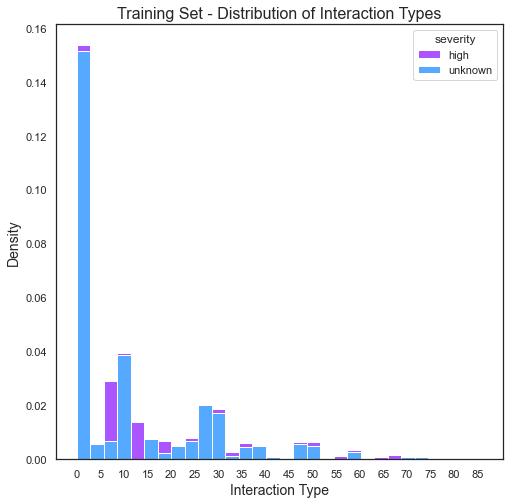

In [122]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=approved_df, x='interaction_type', bins = 30, alpha=1, 
             hue="severity", multiple="stack", palette='cool_r', stat='density')
plt.ylabel('Density', fontsize=14)
plt.xlabel('Interaction Type', fontsize=14)
plt.title('Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 90, 5))
plt.xticks(labels)
plt.show()

In [6]:
from sklearn.utils import resample

def balance_dataset(df, n_samples=10000, random_state=42):
    label_counts = df.interaction_type.value_counts()
    
    ## Downsample Majority cClasses
    # Get majority classes (all labels >= n_samples)
    majority_classes = approved_df.interaction_type.value_counts()\
        [approved_df.interaction_type.value_counts() >= n_samples].index
    
    # Initialize
    df_majorities = pd.DataFrame(data=[], columns=["d1", "d2", "interaction_type", "severity"])
    
    for i in range(len(majority_classes)):
        label = majority_classes[i]
        df_majority = df[df["interaction_type"] == label]
        df_downsample = resample(df_majority,
                                replace=False,     # sample without replacement
                                n_samples=n_samples,    # change majority to minority clas
                                random_state=random_state)
        # Add each majority class to down_sample df:
        # Combine all downsampled majority classes
        df_majorities = pd.concat([df_majorities, df_downsample])
        
        
    ## Upsample Minority Classes
    # Get majority classes (all labels < n_samples)
    minority_classes = approved_df.interaction_type.value_counts()\
        [approved_df.interaction_type.value_counts() < n_samples].index
    
    # Initialize
    df_minorities = pd.DataFrame(data=[], columns=["d1", "d2", "interaction_type", "severity"])
    
    for i in range(len(minority_classes)):
        label = minority_classes[i]
        df_minority = df[df["interaction_type"] == label]
        df_upsample = resample(df_minority,
                                replace=True,     # sample WITH replacement
                                n_samples=n_samples,    # change majority to minority clas
                                random_state=random_state)
        # Add each minority class to up-sample df:
        # Combine all Up-sampled minority classes
        df_minorities = pd.concat([df_minorities, df_upsample])
       
    ## Combine Upsample & Downsample data
    df = pd.concat([df_majorities, df_minorities])
    df = df.sample(frac=1, random_state=42)
    df = df.reset_index()
    df = df.drop('index', axis=1)
    
    return df

### Balance to have 10,000 each label

In [7]:
## Balance data with each label = 3,000 samples
balance_df_3000 = balance_dataset(approved_df, n_samples=3000)
print(balance_df_3000.shape)
balance_df_3000.head(2)

(261000, 4)


,d1,d2,interaction_type,severity
0,DB00460,DB08913,0,unknown
1,DB08893,DB13345,80,unknown


In [71]:
## Balance data with each label = 10,000 samples
balance_df_10000 = balance_dataset(approved_df, n_samples=10000)
print(balance_df_10000.shape)
balance_df_10000.head(2)

(870000, 4)


,d1,d2,interaction_type,severity
0,DB06723,DB14489,47,unknown
1,DB04821,DB00193,51,high


In [10]:
interaction_df = pd.read_csv('data/interaction_information_api.csv', delimiter='\t')
# interaction_df.head()

In [13]:
# Add Interaction Type and Smiles1, Smiles 2 into negative_df
def add_smiles_to_df(df, drug_info_df=drug_info_df, interaction_df=interaction_df):
    drug_info_df = drug_info_df[["drug_id", "generic_name", "SMILES"]]
    df = pd.merge(df, drug_info_df, left_on="d1", right_on="drug_id", how="left")
    df = df.rename(columns={"generic_name": "d1_name", "SMILES": "smiles1"})

    df = pd.merge(df, drug_info_df, left_on="d2", right_on="drug_id", how="left")
    df = df.rename(columns={"generic_name": "d2_name", "SMILES": "smiles2"})
    
    df = pd.merge(df, interaction_df, left_on="interaction_type", right_on="interaction_type", how="left")
    df = df.rename(columns={"interaction_type_x": "interaction_type"})

    df = df[['d1', 'd2', 'd1_name', 'd2_name', 'interaction','interaction_type', 'severity', 'smiles1', 'smiles2']]
    return df

In [14]:
balance_df_3000 = add_smiles_to_df(balance_df_3000)
print('Balance data dimension:', balance_df_3000.shape)
print('Number of distinct drugs in d1:', len(balance_df_3000['d1'].unique()))
print('Number of distinct drugs in d2:', len(balance_df_3000['d2'].unique()))
print('Missing value:', balance_df_3000.isnull().sum())
balance_df_3000.head(2)

Balance data dimension: (261000, 9)
Number of distinct drugs in d1: 2002
Number of distinct drugs in d2: 1998
Missing value: d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
interaction_type    0
severity            0
smiles1             0
smiles2             0
dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00460,DB08913,Verteporfin,Radium Ra 223 dichloride,Unknown,0,unknown,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C(=C\2)/C(CCC(O)=O)=C5C)C(C=C)=C4C)C2=CC=C([C@@H](C(=O)OC)[C@@]32C)C(=O)OC)=C1C,[Cl-].[Cl-].[223Ra++]
1,DB08893,DB13345,Mirabegron,Dihydroergocristine,#Drug2 may increase the hypertensive and vasoconstricting activities of #Drug1.,80,unknown,NC1=NC(CC(=O)NC2=CC=C(CCNC[C@H](O)C3=CC=CC=C3)C=C2)=CS1,[H][C@@]12CCCN1C(=O)[C@H](CC1=CC=CC=C1)N1C(=O)[C@](NC(=O)[C@H]3CN(C)[C@]4([H])CC5=CNC6=CC=CC(=C56)[C@@]4([H])C3)(O[C@@]21O)C(C)C


In [77]:
balance_df_10000 = add_smiles_to_df(balance_df_10000)
print('Balance data dimension:', balance_df_10000.shape)
print('Number of distinct drugs in d1:', len(balance_df_10000['d1'].unique()))
print('Number of distinct drugs in d2:', len(balance_df_10000['d2'].unique()))
print('Missing value:', balance_df_10000.isnull().sum())
balance_df_10000.head(2)

Balance data dimension: (870000, 9)
Number of distinct drugs in d1: 2025
Number of distinct drugs in d2: 2025
Missing value: d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
interaction_type    0
severity            0
smiles1             0
smiles2             0
dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB06723,DB14489,Aluminum hydroxide,Ferrous succinate,#Drug1 can cause a decrease in the absorption of #Drug2 resulting in a reduced serum concentration and potentially a decrease in efficacy.,47,unknown,[OH-].[OH-].[OH-].[Al+3],[Fe++].[O-]C(=O)CCC([O-])=O
1,DB04821,DB00193,Nomifensine,Tramadol,The risk or severity of CNS depression can be increased when #Drug1 is combined with #Drug2.,51,high,CN1CC(C2=CC=CC=C2)C2=C(C1)C(N)=CC=C2,COC1=CC=CC(=C1)C1(O)CCCCC1CN(C)C


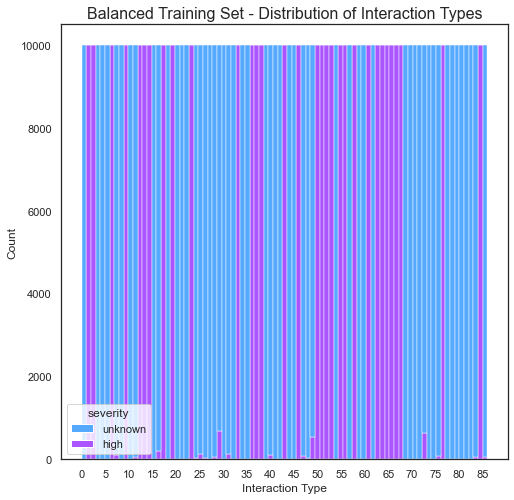

In [124]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=balance_df_10000, x='interaction_type',bins = 87, alpha=1, 
             hue="severity", multiple="stack", palette='cool')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Interaction Type', fontsize=12)
plt.title('Balanced Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 90, 5))
plt.xticks(labels)
plt.show()

In [15]:
# Save Balance Training Data
# save the dataframe to csv file
balance_df_3000.to_csv('data/ddi_train_balanced_3000.csv', index=False, sep='\t')

In [84]:
# Save Balance Training Data
# save the dataframe to csv file
balance_df_10000.to_csv('data/ddi_train_balanced_10000.csv', index=False, sep='\t')

### Balance to have 20,000 each label

In [79]:
## Balance data with each label = 10,000 samples
balance_df_20000 = balance_dataset(approved_df, n_samples=20000)
balance_df_20000 = add_smiles_to_df(balance_df_20000)
print('Balance data dimension:', balance_df_20000.shape)
print('Number of distinct drugs in d1:', len(balance_df_20000['d1'].unique()))
print('Number of distinct drugs in d2:', len(balance_df_20000['d2'].unique()))
print('Missing value:', balance_df_20000.isnull().sum())
balance_df_20000.head(2)

Balance data dimension: (1740000, 9)
Number of distinct drugs in d1: 2035
Number of distinct drugs in d2: 2030
Missing value: d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
interaction_type    0
severity            0
smiles1             0
smiles2             0
dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00450,DB00692,Droperidol,Phentolamine,"#Drug1 may increase the orthostatic hypotensive, hypotensive, and antihypertensive activities of #Drug2.",84,unknown,FC1=CC=C(C=C1)C(=O)CCCN1CCC(=CC1)N1C(=O)NC2=CC=CC=C12,CC1=CC=C(C=C1)N(CC1=NCCN1)C1=CC(O)=CC=C1
1,DB00222,DB04820,Glimepiride,Nialamide,#Drug2 may increase the hypoglycemic activities of #Drug1.,45,unknown,CCC1=C(C)CN(C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)N[C@H]2CC[C@H](C)CC2)C1=O,O=C(CCNNC(=O)C1=CC=NC=C1)NCC1=CC=CC=C1


In [85]:
# save the dataframe to csv file
balance_df_20000.to_csv('data/ddi_train_balanced_20000.csv', index=False, sep='\t')

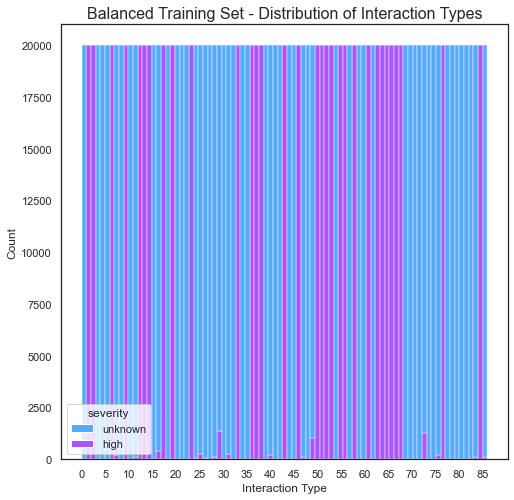

In [125]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=balance_df_20000, x='interaction_type',bins = 87, alpha=1, 
             hue="severity", multiple="stack", palette='cool')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Interaction Type', fontsize=12)
plt.title('Balanced Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 90, 5))
plt.xticks(labels)
plt.show()

### Balance to have 40,000 each label

In [81]:
## Balance data with each label = 40,000 samples
balance_df_40000 = balance_dataset(approved_df, n_samples=40000)
balance_df_40000 = add_smiles_to_df(balance_df_40000)
print('Balance data dimension:', balance_df_40000.shape)
print('Number of distinct drugs in d1:', len(balance_df_40000['d1'].unique()))
print('Number of distinct drugs in d2:', len(balance_df_40000['d2'].unique()))
print('Missing value:', balance_df_40000.isnull().sum())
balance_df_40000.head(2)

Balance data dimension: (3480000, 9)
Number of distinct drugs in d1: 2037
Number of distinct drugs in d2: 2034
Missing value: d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
interaction_type    0
severity            0
smiles1             0
smiles2             0
dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00255,DB01017,Diethylstilbestrol,Minocycline,The serum concentration of #Drug1 can be decreased when it is combined with #Drug2.,26,unknown,CC\C(=C(\CC)C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,[H][C@@]12CC3=C(C(O)=CC=C3N(C)C)C(=O)C1=C(O)[C@]1(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@]1([H])C2
1,DB11921,DB01108,Deflazacort,Trilostane,The risk or severity of edema formation can be increased when #Drug1 is combined with #Drug2.,65,high,[H][C@@]12C[C@@]3([H])[C@]4([H])CCC5=CC(=O)C=C[C@]5(C)[C@@]4([H])[C@@]([H])(O)C[C@]3(C)[C@@]1(N=C(C)O2)C(=O)COC(C)=O,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC[C@@]23O[C@@H]2C(O)=C(C[C@]13C)C#N


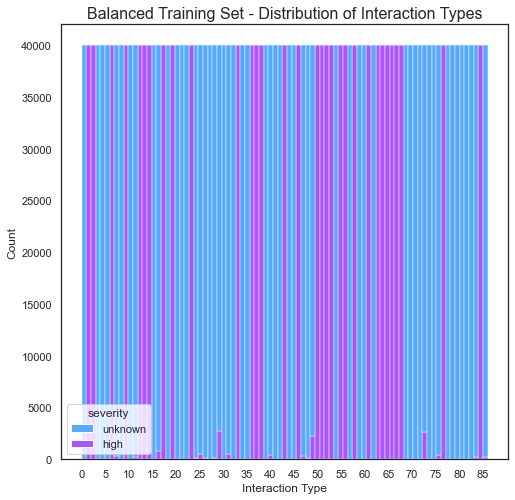

In [126]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=balance_df_40000, x='interaction_type',bins = 87, alpha=1, 
             hue="severity", multiple="stack", palette='cool')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Interaction Type', fontsize=12)
plt.title('Balanced Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 90, 5))
plt.xticks(labels)
plt.show()

In [86]:
# save the dataframe to csv file
balance_df_40000.to_csv('data/ddi_train_balanced_40000.csv', index=False, sep='\t')